In [21]:
import os
import io
from PIL import Image, ImageDraw
import pandas as pd
import numpy as np
import csv, shutil
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn import cluster
import ujson as json
import random
%matplotlib inline
new_style = {'grid': False}
plt.rc('axes', **new_style)
random.seed(100);

In [2]:
# Set working directory
os.chdir('../data/fish/')
path = ""

In [3]:
os.getcwd()

'/home/darragh/Dropbox/fish/data/fish'

In [4]:
def refresh_directory_structure(name, sub_dirs):
    gdir = os.path.join(path, name)
    if os.path.exists(gdir):
        shutil.rmtree(gdir)
    os.makedirs(gdir)
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(gdir, sub_dir))

### Load Bound Box

In [5]:
# get the different types
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [6]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('box/{}_labels.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]


empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [7]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

### Refresh directories

In [63]:
refresh_directories = True
# Create the test and valid directory
if refresh_directories:
    sub_dirs = os.listdir(os.path.join(path, 'train-all'))
    if '.DS_Store' in sub_dirs: sub_dirs.remove('.DS_Store')
    refresh_directory_structure('train-crop', sub_dirs)
    refresh_directory_structure('valid-crop', sub_dirs)
    for c,row in enumerate(csv.DictReader(open('../../image_validation_set.csv'))):
        value = 'valid-crop' if row['Validation'] == '1' else 'train-crop'
        name_from = os.path.join(path, 'train-all', row['SubDirectory'], row['file_name'])
        name_to   = os.path.join(path, value, row['SubDirectory'], row['file_name'])
        shutil.copyfile(name_from, name_to)

### Get the files

In [9]:
for sub_dir in os.listdir('train-crop'):
    trnp = os.path.join('train-crop', sub_dir)
    valp = os.path.join('valid-crop', sub_dir)
    raw_filenames = os.listdir(trnp)
    raw_val_filenames = os.listdir(valp)
    for f in raw_filenames:
        if not f in bb_json.keys(): bb_json[f] = empty_bbox
        bb_json[f]['size'] = Image.open(os.path.join(trnp, f)).size
    for f in raw_val_filenames:
        if not f in bb_json.keys(): bb_json[f] = empty_bbox
        bb_json[f]['size'] = Image.open(os.path.join(valp, f)).size

In [10]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 'size': (1280, 974),
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [11]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb):
    size0, size1 = bb['size'][0], bb['size'][1]
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size0)
    conv_y = (224. / size1)
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [12]:
convert_bb(bb_json['img_04908.jpg'])

[56.747433264887235, 75.75225000000023, 81.42750000000024, 114.14340862423032]

In [13]:
trn_bbox = np.stack([convert_bb(bb_json[f]) for f in raw_filenames]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f]) for f in raw_val_filenames]).astype(np.float32)

In [14]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

In [15]:
def draw_rect(ax, filename):
    bb = bb_json[filename]
    rect = patches.Rectangle((bb['x']-20, bb['y']-20), bb['width']+40, bb['height']+40,linewidth=1,edgecolor='r',facecolor='none', lw=3)
    return ax.add_patch(rect)

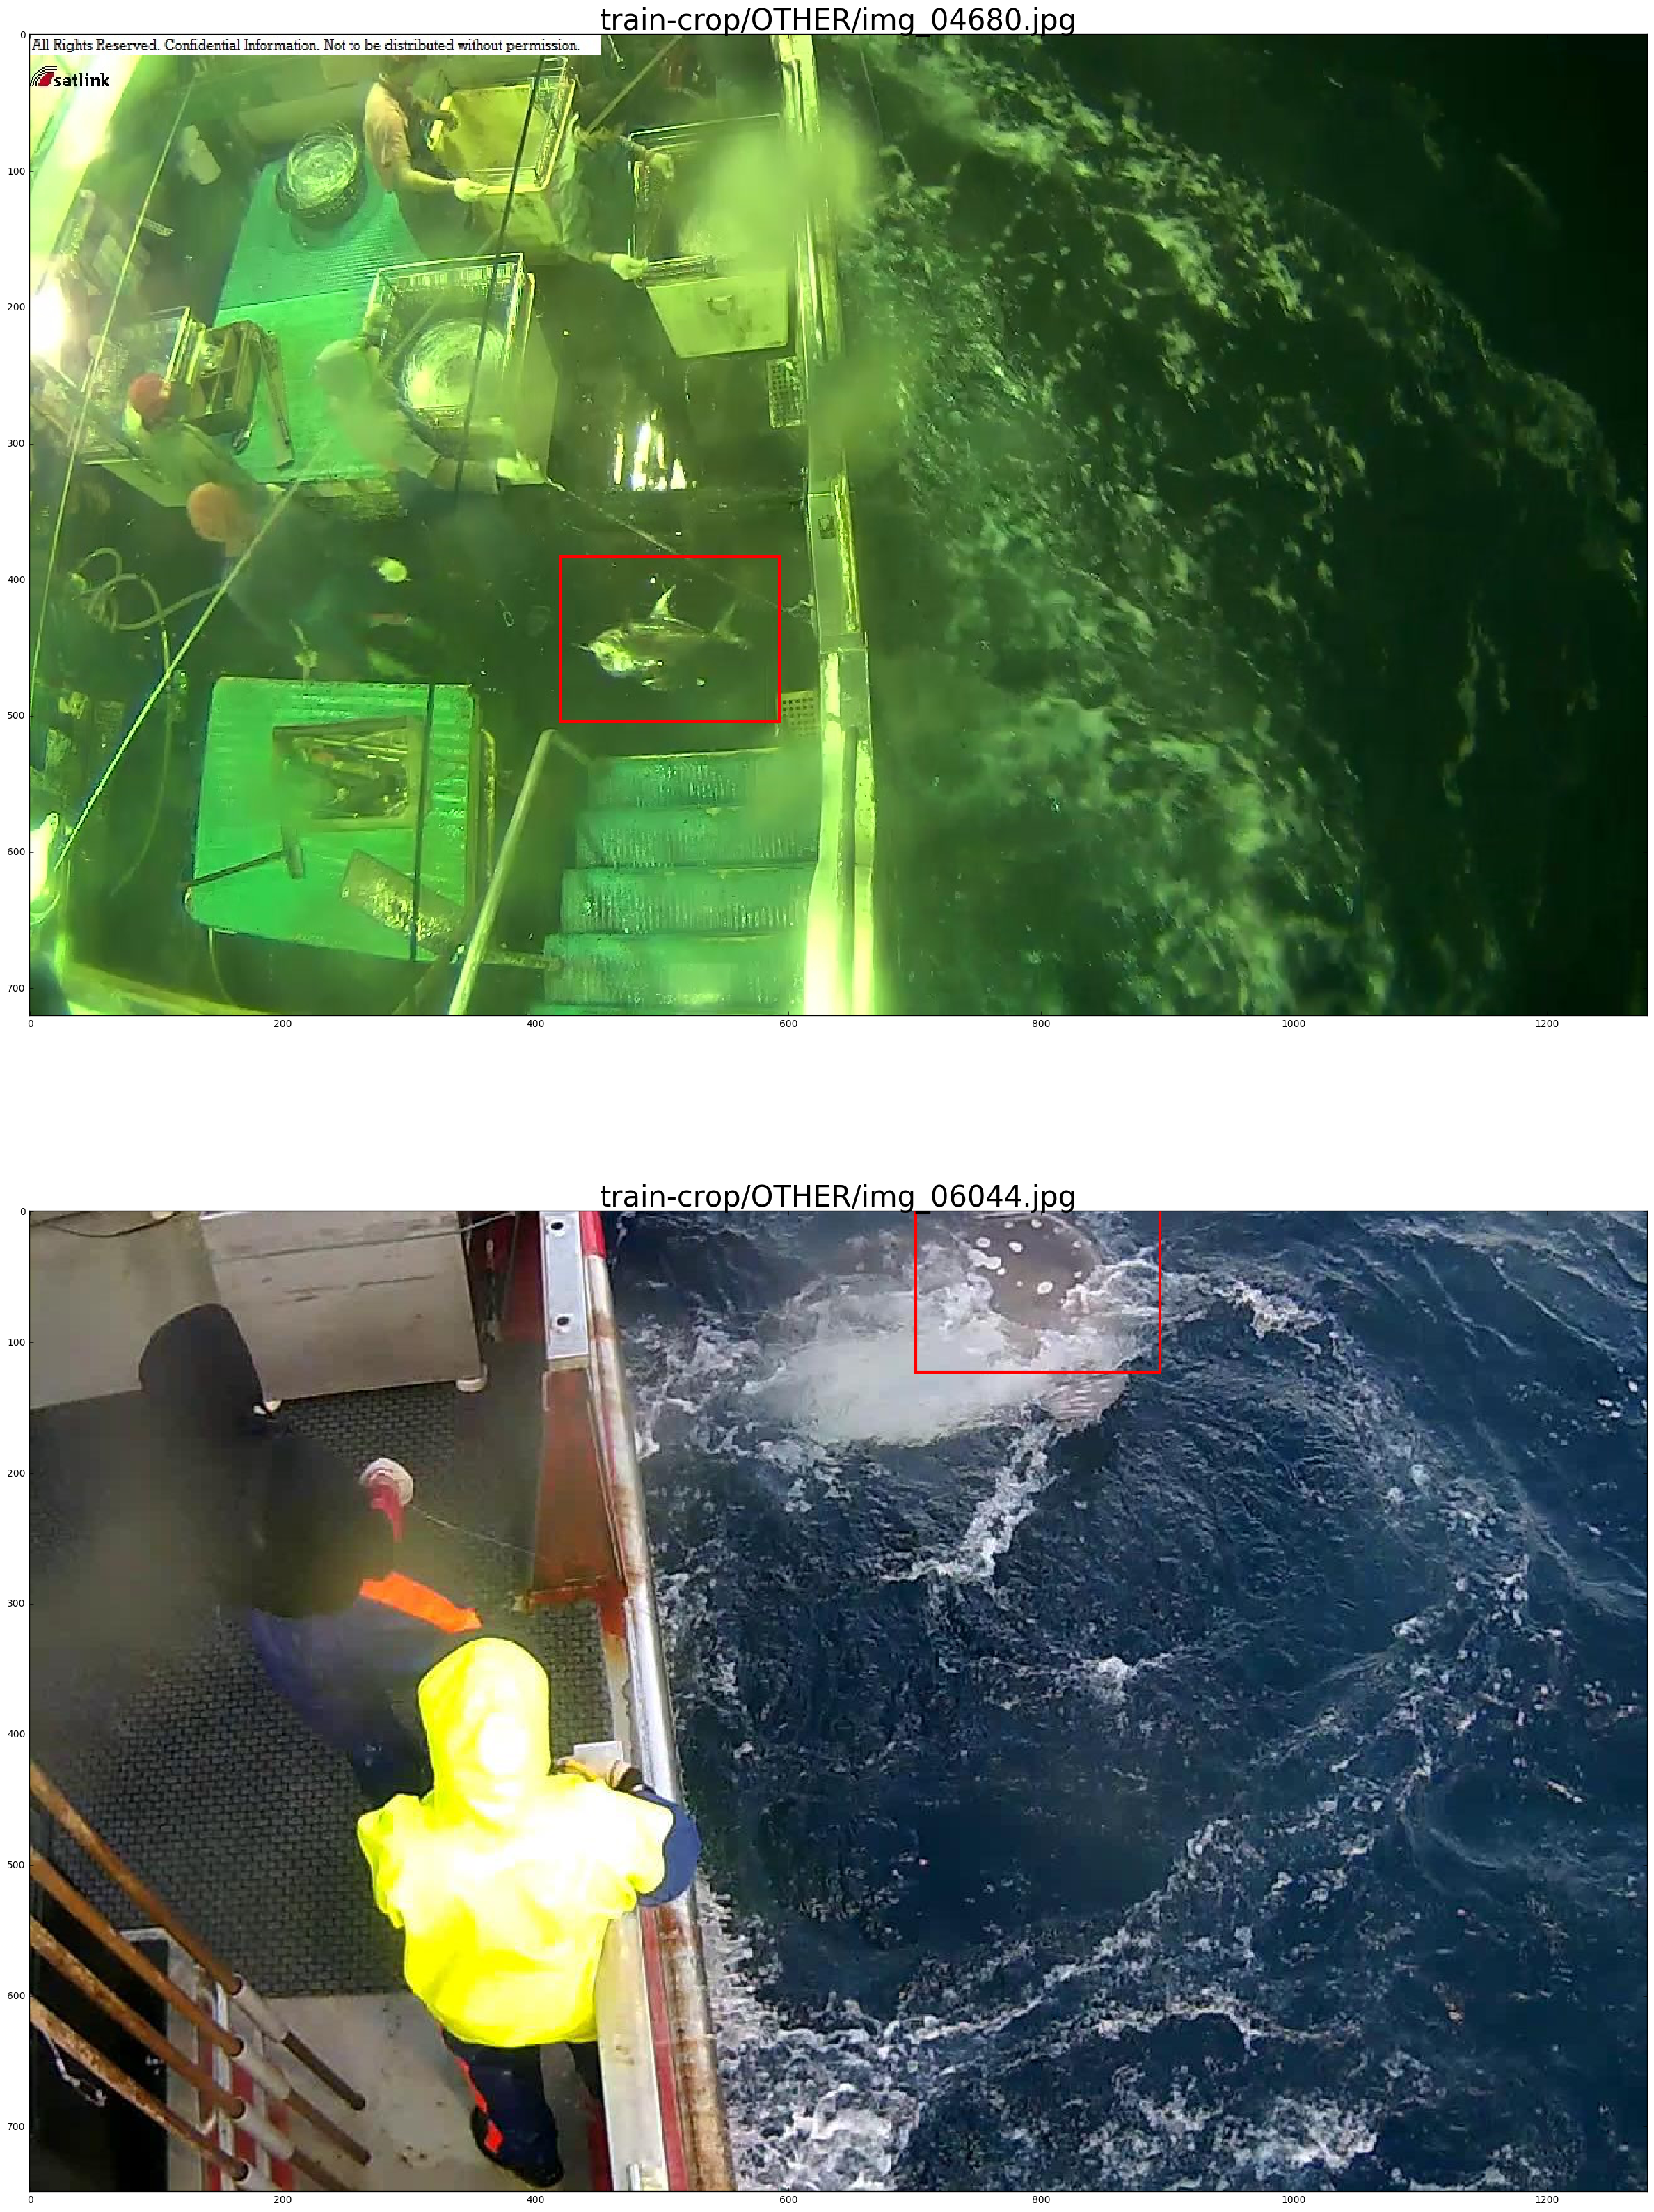

In [16]:
counter = 0
_, ax = plt.subplots(2, 1, figsize=(30, 40))
ax = ax.flatten()
for c in range(len(raw_filenames)):
    if counter  == len(ax): 
        break
    f = raw_filenames[c]
    imgdata = Image.open(os.path.join(trnp, f))
    axis = ax[c]
    draw_rect(axis, f)
    axis.set_title(os.path.join(trnp, f), fontsize=30)
    axis.imshow(np.asarray(imgdata), interpolation='nearest', aspect='auto')    
    counter += 1


In [17]:
sub_dirs

['DOL', 'YFT', 'NoF', 'SHARK', 'ALB', 'LAG', 'BET', 'OTHER']

In [64]:
print_boxes = False # or crop

for pdir in ['train-crop', 'valid-crop']:
    for sdir in sub_dirs:
        print os.path.join(pdir, sdir)
        for f in os.listdir(os.path.join(pdir, sdir)):
            bb = bb_json[f]
            img =  Image.open(os.path.join(pdir, sdir, f))
            dr = ImageDraw.Draw(img)
            max_dirn = max(bb['width'], bb['height'])
            cor = ( bb['x']-20, bb['y']-20, max_dirn+bb['x']+20, max_dirn+bb['y']+20) # (x1,y1, x2,y2)
            if print_boxes:
                dr.rectangle(cor, outline="red")
            else:
                img = img.crop(cor)
            img.save(os.path.join(pdir, sdir, f))


train-crop/DOL
train-crop/YFT
train-crop/NoF
train-crop/SHARK
train-crop/ALB
train-crop/LAG
train-crop/BET
train-crop/OTHER
valid-crop/DOL
valid-crop/YFT
valid-crop/NoF
valid-crop/SHARK
valid-crop/ALB
valid-crop/LAG
valid-crop/BET
valid-crop/OTHER


In [60]:
#from PIL import Image, ImageDraw

img =  Image.open('train-crop/ALB/img_00010.jpg')
img.save('img_orig.png')
bb = bb_json['img_00010.jpg']
dr = ImageDraw.Draw(img)
max_dirn = max(bb['width'], bb['height'])
cor = ( bb['x']-20, bb['y']-20, max_dirn+bb['x']+20, max_dirn+bb['y']+20) # (x1,y1, x2,y2)
dr.rectangle(cor, outline="red")
#img = img.crop(cor)
img.save('img_boxed.png')